<a href="https://colab.research.google.com/github/vitaldb/examples/blob/master/pyvital.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to analyze biosignal data using Pyvital library
In this example, we will learn how to analyze biosinal data using `pyvital` library. For more information about `pyvital` library, see: https://github.com/vitaldb/pyvital

## Download 'pyvital' library
Install `pyvital` and `vitaldb` library using `pip`.

In [1]:
!pip install pyvital vitaldb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Read sample data
Read sample biosignal data using `vitaldb` python library.

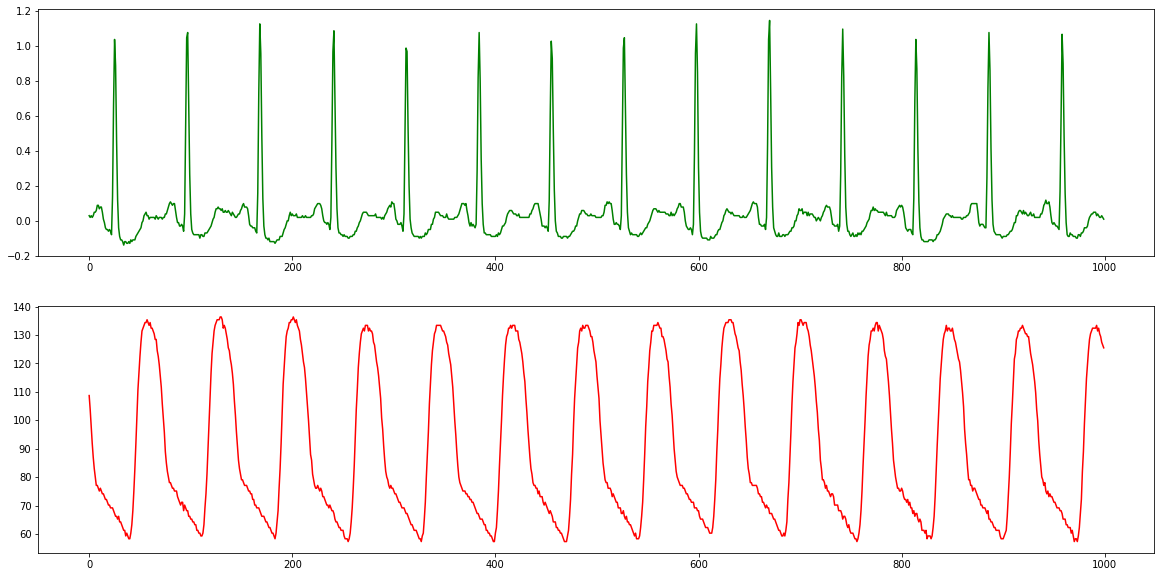

In [2]:
import vitaldb
srate = 100
vals = vitaldb.load_case(1, ['SNUADC/ECG_II','SNUADC/ART'], 1 / srate)

import matplotlib.pyplot as plt
ecg = vals[110000:111000, 0]
art = vals[110000:111000, 1]
plt.figure(figsize=(20,10))
plt.subplot(211)
plt.plot(ecg, color='g')
plt.subplot(212)
plt.plot(art, color='r')
plt.show()

## Detect R peak from ECG
`pyvital` library has a nice QRS detector which implements the Pan and Tompkins algorithm. This example use `pyvital.arr.detect_qrs(data, srate)` to finds R peaks from ECG signal.
> Reference. Pan and Tompkins, A Real-Time QRS Detection Algorithm. IEEE Transactions on Biomedical Engineering BME-32.3 (1985)



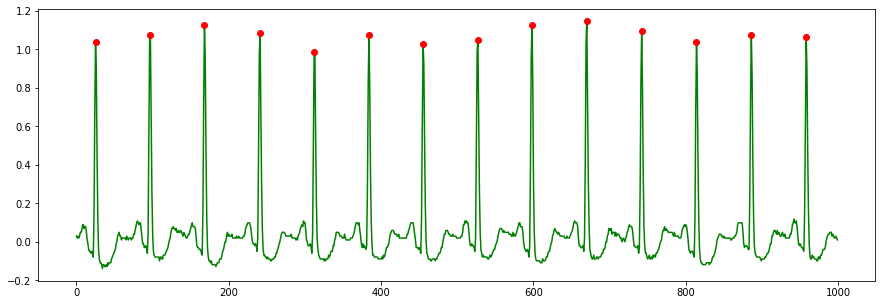

In [3]:
import pyvital.arr
ecg = vals[110000:111000, 0]
ecg = pyvital.arr.exclude_undefined(ecg)
peaks = pyvital.arr.detect_qrs(ecg, srate) # find qrs and return the indexes

plt.figure(figsize=(15,5))
plt.plot(ecg, color='g')
plt.plot(peaks, [ecg[i] for i in peaks], 'ro')
plt.show()

## Detect peaks from arterial pressure waveform
`pyvital.arr.detect_peaks(data, srate)` obtains peaks and valleys from blood pressure or pleth waveform. The number of valleys is always one less than the number of peaks.

[[110, 183, 255, 327, 398, 468, 539, 611, 682, 756, 825, 898], [57, 129, 201, 272, 342, 415, 489, 560, 630, 700, 775, 850, 919]]


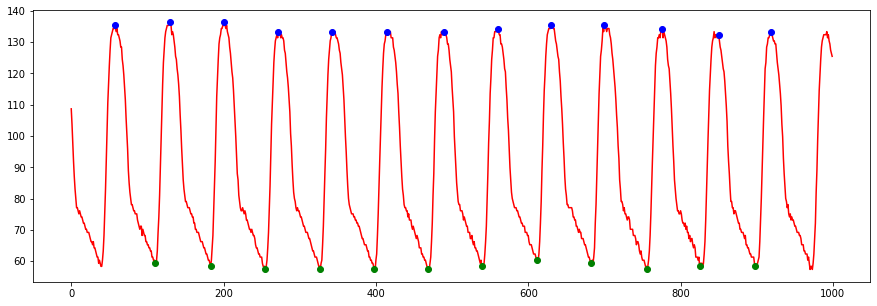

In [4]:
art = pyvital.arr.exclude_undefined(art)
peaks = pyvital.arr.detect_peaks(art, 100) # Obtain maximum and minimum values from blood pressure or pleth waveform
print(peaks)

plt.figure(figsize=(15,5))
plt.plot(art, color='r')
plt.plot(peaks[0], [art[i] for i in peaks[0]], 'go') # minimum values from BP or pleth waveform
plt.plot(peaks[1], [art[i] for i in peaks[1]], 'bo') # maximum values from BP or pleth waveform
plt.show()

## How to apply filter
You can apply filters in the vital recorder using the pyvital library.

### Apply filter to biosignal data
In this example, we will apply Pulse Pressure Variation (PPV) filter to the arterial waveform downloaded above.

In [5]:
# loading the ppv filter module
import pyvital.filters.abp_ppv as f
f.cfg

{'desc': 'Calculate pulse pressure variation using modified version of the method in the reference',
 'group': 'ABP',
 'inputs': [{'name': 'ART', 'type': 'wav'}],
 'interval': 30,
 'name': 'ART - Pulse Pressure Variation',
 'outputs': [{'max': 30, 'min': 0, 'name': 'PPV', 'type': 'num', 'unit': '%'},
  {'max': 30, 'min': 0, 'name': 'SPV', 'type': 'num', 'unit': '%'},
  {'max': 30, 'min': 0, 'name': 'ART_RR', 'type': 'num', 'unit': '/min'}],
 'overlap': 20,
 'reference': 'Aboy et al, An Enhanced Automatic Algorithm for Estimation of Respiratory Variations in Arterial Pulse Pressure During Regions of Abrupt Hemodynamic Changes. IEEE TRANSACTIONS ON BIOMEDICAL ENGINEERING, VOL. 56, NO. 10, OCTOBER 2009'}

Let's apply a PPV filter that reads arterial pressure at 100 Hz.

In [6]:
art = vals[300000:306000, 1]
res = f.run({'ART':{'srate':100, 'vals':art}}, {}, f.cfg)
res[0]

[{'dt': 30, 'val': 2.2948821365514287}]

### Apply filter to vital file
You can also apply filter to track in vital file and then save the results to the other vital file.

In [8]:
import vitaldb
import pyvital.filters.ecg_hrv as f

vf = vitaldb.VitalFile('https://vitaldb.net/samples/00001.vital')

SRATE = 100
INPUT_TRACK_NAME = 'SNUADC/ECG_II'
vals = vf.to_numpy(INPUT_TRACK_NAME, 1/SRATE).flatten()

# run filter
import numpy as np
output_recs = []
for output in f.cfg['outputs']:
    output_recs.append([])

for dtstart_seg in np.arange(vf.dtstart, vf.dtend, f.cfg['interval'] - f.cfg['overlap']):
    dtend_seg = dtstart_seg + f.cfg['interval']
    idx_dtstart = int((dtstart_seg - vf.dtstart) * SRATE)
    idx_dtend = int((dtend_seg - vf.dtstart) * SRATE)
    outputs = f.run({f.cfg['inputs'][0]['name']: {'srate':SRATE, 'vals': vals[idx_dtstart:idx_dtend]}}, {}, f.cfg)
    if outputs is None:
        continue
    for i in range(len(f.cfg['outputs'])):
        output = outputs[i]
        for rec in output:  # convert relative time to absolute time
            rec['dt'] += dtstart_seg
            output_recs[i].append(rec)

# save to vital file
new_dtnames = []  # added tracks
for i in range(len(f.cfg['outputs'])):
    dtname = f.cfg['outputs'][i]['name']
    vf.add_track(dtname, output_recs[i], after=INPUT_TRACK_NAME)
    new_dtnames.append(dtname)

# add track after INPUT_TRACK_NAME
if not hasattr(vf, 'order') or len(vf.order) == 0:
    vf.order = list(vf.trks.keys())
pos = vf.order.index(INPUT_TRACK_NAME)
vf.order = vf.order[:pos+1] + new_dtnames + vf.order[pos+1:]

vf.to_vital('filtered.vital')

True